In [24]:
import numpy as np 
import pandas as pd 
import seaborn as sns; sns.set(style="ticks", color_codes=True)

import matplotlib as mpl
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import os

import geopandas as gpd
import shapely
from shapely.geometry import Point
from matplotlib.colors import ListedColormap


In [3]:
# Customised Color Palette
colors=["#7831F9","#C22989","#DE1149","#AE8281","#69BA31"]
cmap = ListedColormap(colors)

In [4]:
dept_35_pov = pd.read_csv('./Dept_35-00103/35-00103_ACS_data/35-00103_ACS_poverty/ACS_16_5YR_S1701_with_ann.csv').iloc[1:].reset_index(drop=True)
dept_35_race = pd.read_csv('./Dept_35-00103/35-00103_ACS_data/35-00103_ACS_race-sex-age/ACS_15_5YR_DP05_with_ann.csv').iloc[1:].reset_index(drop=True)
dept_35_edu = pd.read_csv('./Dept_35-00103/35-00103_ACS_data/35-00103_ACS_education-attainment-over-25/ACS_16_5YR_B15003_with_ann.csv').iloc[1:].reset_index(drop=True)

police_arrest_df = pd.read_csv('./Dept_35-00103/35-00103_UOF-OIS-P_prepped.csv').iloc[1:].reset_index(drop=True)
police_shp_gdf = gpd.read_file('./Dept_35-00103/35-00103_Shapefiles/CMPD_Police_Division_Offices.shp')

In [5]:
dept_35_pov['HC02_EST_VC01'] = dept_35_pov['HC02_EST_VC01'].apply(int)

total_population = pd.to_numeric(dept_35_pov['HC01_EST_VC01'][1:]).sum()
below_pv_line = ((pd.to_numeric(dept_35_pov['HC02_EST_VC01'][1:]).sum()) / total_population) * 100

## Mecklenburg Country, North Carolina

**Total Population**: 992,212 

**Percent Below Poverty Line**: 14.17%

#### Distributions  of Race

Let's have a look at the distributions of race across the state, I decided to draw a boxplot around this to get an idea of the spread of each category of race.

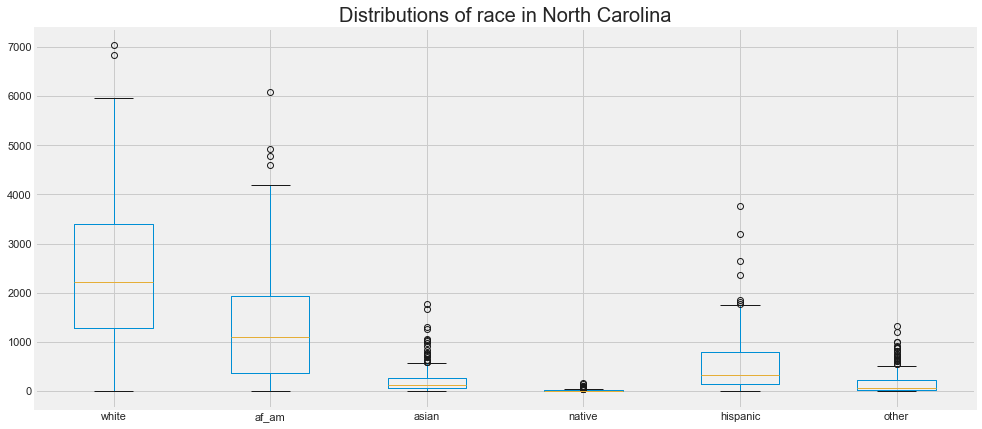

In [6]:

race_df = pd.DataFrame({
    'white': pd.to_numeric(dept_35_race['HC01_VC49']),
    'af_am':pd.to_numeric(dept_35_race['HC01_VC50']),
    'asian':pd.to_numeric(dept_35_race['HC01_VC56']),
    'native':pd.to_numeric(dept_35_race['HC01_VC51']),
    'hispanic': pd.to_numeric(dept_35_race['HC01_VC88']),
    'other': pd.to_numeric(dept_35_race['HC01_VC69'])
}, columns=['white','af_am','asian','native', 'hispanic','other'])
fig1, ax1 = plt.subplots(figsize=(15,7))
ax1.set_title("Distributions of race in North Carolina", fontsize=20)
race_df.plot.box(ax=ax1)

#### Results:
From the boxplot above it is evident that the White race is quite dominant in the state followed by a strong african american population. The circles above the boxplot indicate outliers per region. From the graph we can conclude that the average population of the White race is approximately **~2200** per tract, and the average African American population per district is just above **1000**.

#### Age distribution across the state. 

Let's have a look at how the ages compare across the state, in the same way we did above. 

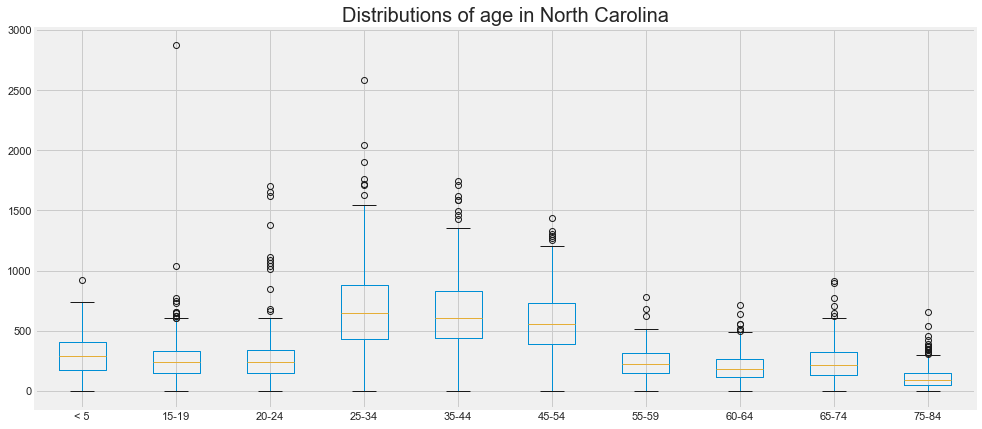

In [7]:
age_hist = pd.DataFrame({
    '< 5': pd.to_numeric(dept_35_race['HC01_VC08']),
    '15-19': pd.to_numeric(dept_35_race['HC01_VC11']),
    '20-24': pd.to_numeric(dept_35_race['HC01_VC12']),
    '25-34': pd.to_numeric(dept_35_race['HC01_VC13']),
    '35-44':pd.to_numeric(dept_35_race['HC01_VC14']),
    '45-54':pd.to_numeric(dept_35_race['HC01_VC15']),
    '55-59':pd.to_numeric(dept_35_race['HC01_VC16']),
    '60-64':pd.to_numeric(dept_35_race['HC01_VC17']),
    '65-74':pd.to_numeric(dept_35_race['HC01_VC18']),
    '75-84':pd.to_numeric(dept_35_race['HC01_VC19'])
}, columns=['< 5','15-19','20-24','25-34','35-44','45-54','55-59','60-64','65-74','75-84'])
fig2, ax2 = plt.subplots(figsize=(15,7))
ax2.set_title("Distributions of age in North Carolina", fontsize=20)
age_hist.plot.box(ax=ax2)

#### Results
From the graph above we can see a rise in distribution across the 25-54 range, so it is fair to conclude the median age is somewhere around 34-44.

### Education:

In [8]:
eduation_df = pd.DataFrame({
    'no_schooling': pd.to_numeric(dept_35_edu['HD01_VD02']),
    'regular_high_school_diploma':pd.to_numeric(dept_35_edu['HD01_VD17']),
    'college_no_degree':pd.to_numeric(dept_35_edu['HD01_VD20']),
    'associates_degree':pd.to_numeric(dept_35_edu['HD01_VD21']),
    'bachelors_degree':pd.to_numeric(dept_35_edu['HD01_VD22']),
    'masters_degree':pd.to_numeric(dept_35_edu['HD01_VD23']),
    'doctorate':pd.to_numeric(dept_35_edu['HD01_VD25'])
}, columns=['no_schooling','regular_high_school_diploma','college_no_degree','associates_degree','bachelors_degree','masters_degree','doctorate'])

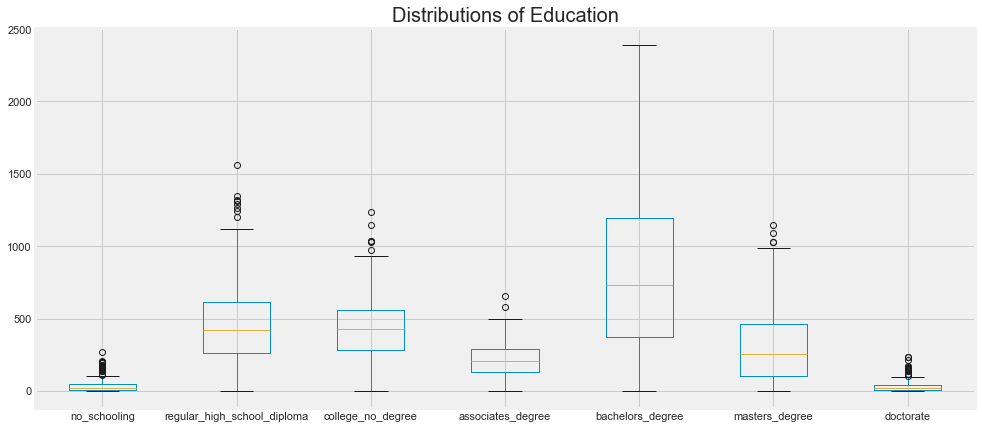

In [9]:
fig2t, ax2t = plt.subplots(figsize=(15,7))
ax2t.set_title("Distributions of Education", fontsize=20)
eduation_df.plot.box(ax=ax2t)


### Results
As a state North Carolina seems to be a well educated, with a majority of people who went to college and got a bachelors degree, but it is still not evident where these areas of high education are. 
This is where the geoplots below will help.

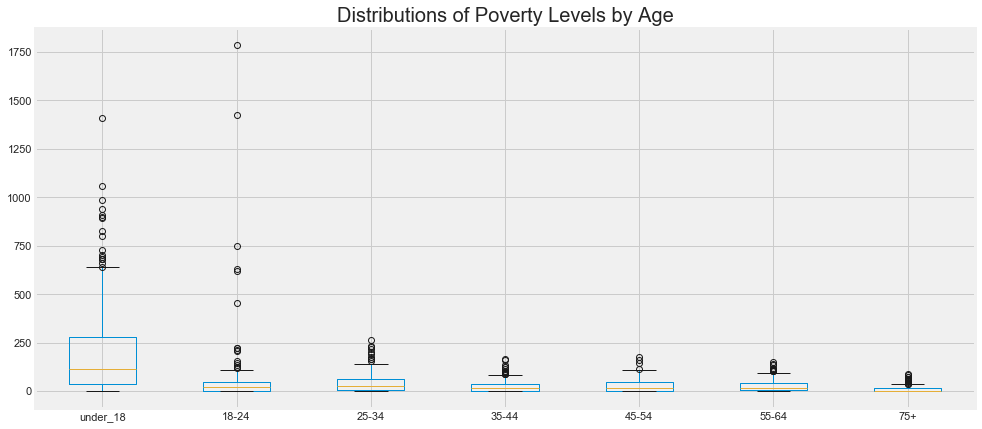

In [10]:
pov_df = pd.DataFrame({
    'under_18': pd.to_numeric(dept_35_pov['HC02_EST_VC03']),
    '18-24': pd.to_numeric(dept_35_pov['HC02_EST_VC67']),
    '25-34':pd.to_numeric(dept_35_pov['HC02_EST_VC68']),
    '35-44':pd.to_numeric(dept_35_pov['HC02_EST_VC69']),
    '45-54':pd.to_numeric(dept_35_pov['HC02_EST_VC70']),
    '55-64':pd.to_numeric(dept_35_pov['HC02_EST_VC71']),
    '75+':pd.to_numeric(dept_35_pov['HC02_EST_VC73']),
}, columns=['under_18','18-24','25-34','35-44','45-54','55-64','75+'])

fig2t1, ax2t1 = plt.subplots(figsize=(15,7))
ax2t1.set_title("Distributions of Poverty Levels by Age", fontsize=20)
pov_df.plot.box(ax=ax2t1)

### Results
There seems to be a high youth poverty rate over other ages in North Carolina, mostly under 18, but there are a few outliers in the 18-24 range, this corresponds to the age of most arrests distribution further down.

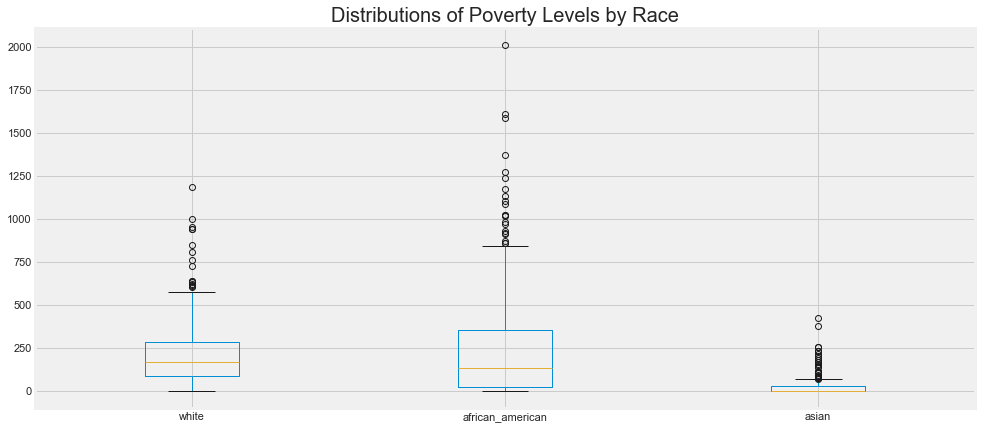

In [11]:
pov_df_race = pd.DataFrame({
    'white': pd.to_numeric(dept_35_pov['HC02_EST_VC18']),
    'african_american': pd.to_numeric(dept_35_pov['HC02_EST_VC19']),
    'asian':pd.to_numeric(dept_35_pov['HC02_EST_VC21']),
}, columns=['white','african_american','asian'])

fig2t2, ax2t2 = plt.subplots(figsize=(15,7))
ax2t2.set_title("Distributions of Poverty Levels by Race", fontsize=20)
pov_df_race.plot.box(ax=ax2t2)

### Results
The distribution of african american poverty levels are a bit higher than the white population, however there are a higher range of outliers for african americans in parts of North Carolina.

### Geoplotting
Let's now have a look at plotting the North Carolina district and see if there is any patterns we can obtain from the results in terms of the arrests and areas.

In [12]:
latlon_exists_index = police_arrest_df[['LOCATION_LATITUDE','LOCATION_LONGITUDE']].dropna().index

police_arrest_df = police_arrest_df.iloc[latlon_exists_index].reset_index(drop=True)
police_arrest_df['LOCATION_LATITUDE'] = (police_arrest_df['LOCATION_LATITUDE'].astype(float))
police_arrest_df['LOCATION_LONGITUDE'] = (police_arrest_df['LOCATION_LONGITUDE'].astype(float))

In [13]:
police_arrest_df['geometry'] = (police_arrest_df.apply(lambda x: Point(x['LOCATION_LONGITUDE'], 
                                                                      x['LOCATION_LATITUDE']), axis=1))

police_arrest_gdf = gpd.GeoDataFrame(police_arrest_df, geometry='geometry')
police_arrest_gdf = police_arrest_gdf.dropna(axis=0)
police_arrest_gdf['INCIDENT_YEAR'] = police_arrest_gdf['INCIDENT_DATE'].apply(lambda x: x.split('-')[0])
police_arrest_gdf.crs = {'init':'epsg:4326'}

In [14]:
police_shp_gdf = police_shp_gdf.to_crs(epsg=4326)

In [15]:
nc_tract = gpd.read_file('./cb_2017_37_tract_500k_NC/cb_2017_37_tract_500k.shp')
dept_35_pov = dept_35_pov.rename(columns={'GEO.id2':'GEOID'})
dept_35_edu = dept_35_edu.rename(columns={'GEO.id2':'GEOID'})
dept_35_race = dept_35_race.rename(columns={'GEO.id2':'GEOID'})

census_merged = nc_tract.merge(dept_35_pov, on = 'GEOID') 
census_merged_edu = nc_tract.merge(dept_35_edu, on = 'GEOID')
census_merged_race = nc_tract.merge(dept_35_race, on='GEOID')

census_merged = census_merged.to_crs(epsg = 4326)
census_merged_edu = census_merged_edu.to_crs(epsg = 4326)
census_merged_race = census_merged_race.to_crs(epsg = 4326)

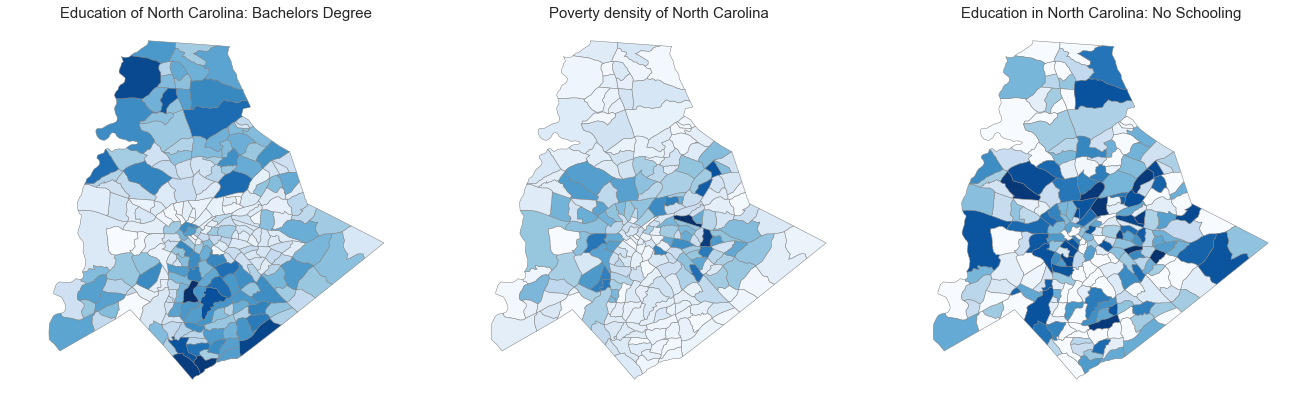

In [16]:
# North Carolina Poverty Map.
census_merged_edu['HD01_VD22'] = census_merged_edu['HD01_VD22'].apply(int)
fig3t, (ax3t1, ax3t2,ax3t3) = plt.subplots(nrows=1, ncols=3)

census_merged_edu.plot(ax=ax3t1, edgecolor='grey', column="HD01_VD22", cmap='Blues')
census_merged.plot(ax=ax3t2, edgecolor='grey', column="HC02_EST_VC01", cmap='Blues')
census_merged_edu.plot(ax=ax3t3, edgecolor='grey', column="HD01_VD02", cmap='Blues')

ax3t1.set_title("Education of North Carolina: Bachelors Degree", fontsize=15)
ax3t2.set_title("Poverty density of North Carolina", fontsize=15)
ax3t3.set_title("Education in North Carolina: No Schooling", fontsize=15)

ax3t1.set_axis_off()
ax3t2.set_axis_off()
ax3t3.set_axis_off()

fig3t.set_size_inches(20,16)

### Results

There seems to be a correlation between education levels and poverty levels, districts with higher education tend to have less poverty, this seems obvious and can be proven true above. There are also areas in the North Carolina where there is a large populus of No Schooling, this also correlates to the areas where poverty is higher. 

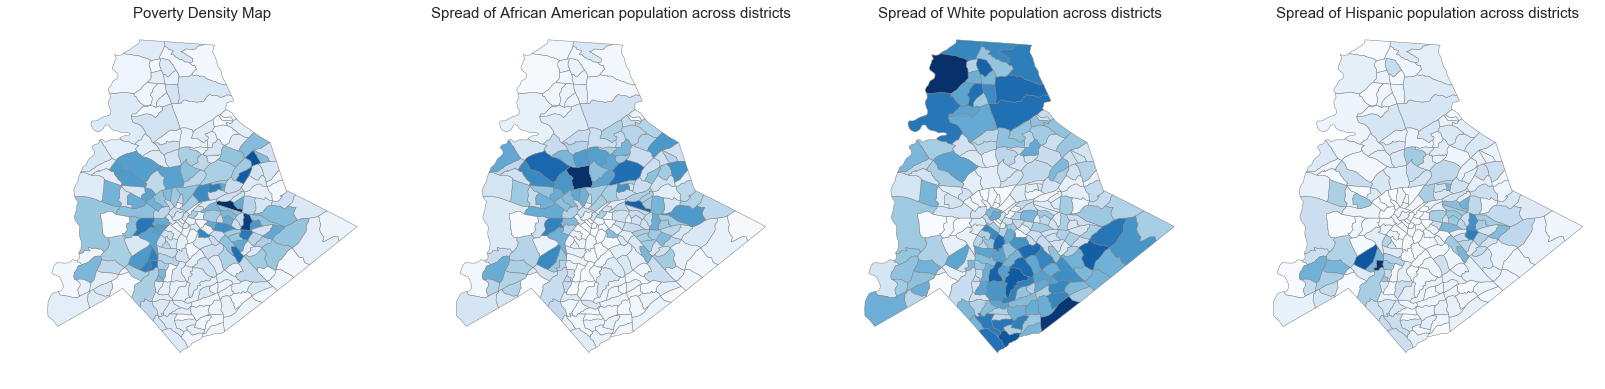

In [17]:
# North Carolina Race Map.
census_merged_race['HC01_VC50'] = census_merged_race['HC01_VC50'].apply(int) # African American
census_merged_race['HC01_VC49'] = census_merged_race['HC01_VC49'].apply(int) # White
census_merged_race['HC01_VC88'] = census_merged_race['HC01_VC88'].apply(int) # Hispanic

fig3t1, (ax3t01,ax3t11, ax3t21,ax3t31) = plt.subplots(nrows=1, ncols=4)

census_merged.plot(ax=ax3t01, edgecolor='grey', column="HC02_EST_VC01", cmap='Blues')
census_merged_race.plot(ax=ax3t11, edgecolor='grey', column="HC01_VC50", cmap='Blues')
census_merged_race.plot(ax=ax3t21, edgecolor='grey', column="HC01_VC49", cmap='Blues')
census_merged_race.plot(ax=ax3t31, edgecolor='grey', column="HC01_VC88", cmap='Blues')

ax3t01.set_title("Poverty Density Map", fontsize=15)
ax3t11.set_title("Spread of African American population across districts", fontsize=15)
ax3t21.set_title("Spread of White population across districts", fontsize=15)
ax3t31.set_title("Spread of Hispanic population across districts", fontsize=15)

ax3t01.set_axis_off()
ax3t11.set_axis_off()
ax3t21.set_axis_off()
ax3t31.set_axis_off()

fig3t1.set_size_inches(25,20)

### Results
From the map above we can start to see a similarity between the poverty density and the spread of the african american population. This is where most of the arrests seems to be made aswell. 

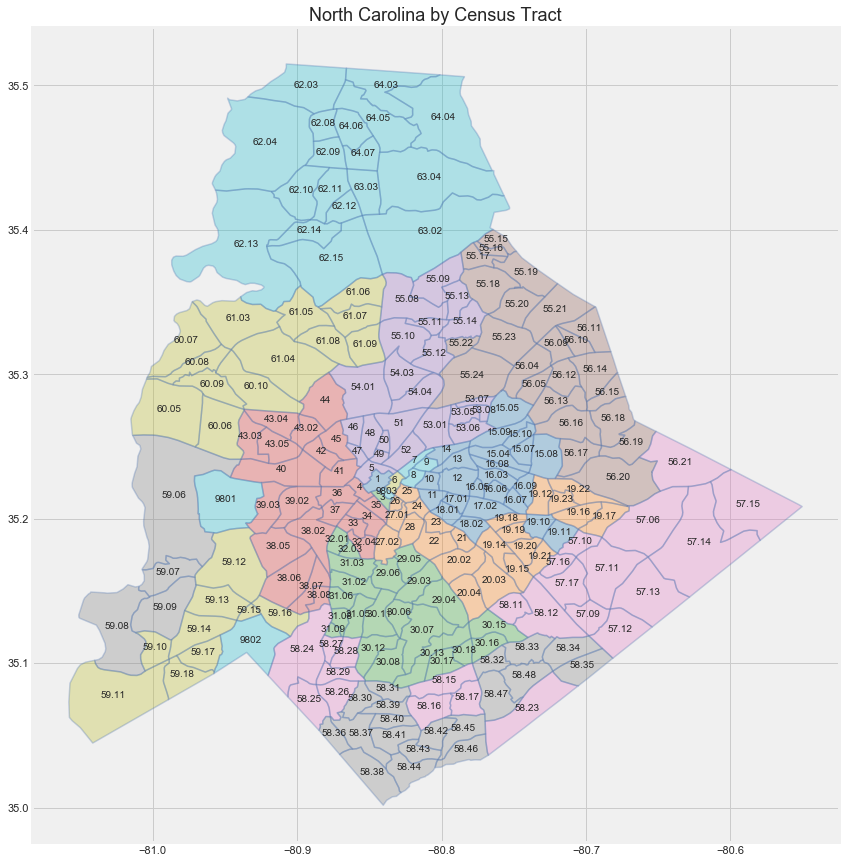

In [18]:
census_merged['coords'] = census_merged['geometry'].apply(lambda x: x.representative_point().coords[:])
census_merged['coords'] = [coords[0] for coords in census_merged['coords']]

fig4t2, ax4t2 = plt.subplots()
ax4t2.set_title("North Carolina by Census Tract", fontsize=18)
census_merged.plot(ax=ax4t2, column="NAME",edgecolor='b', linewidth = 1.5, alpha=.3)
census_merged.apply(lambda x: ax4t2.annotate(s=x.NAME, xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
fig4t2.set_size_inches(15,15)

### Getting Police Districts in North Carolina

The `police_shp_gdf` is supposed to represent the police divisions in North Carolina, however observing the data they only give the point locations of the district, so we can use a spatial join to get a better visual of the area each district covers.

/Users/joshishushruth/anaconda3/lib/python3.5/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


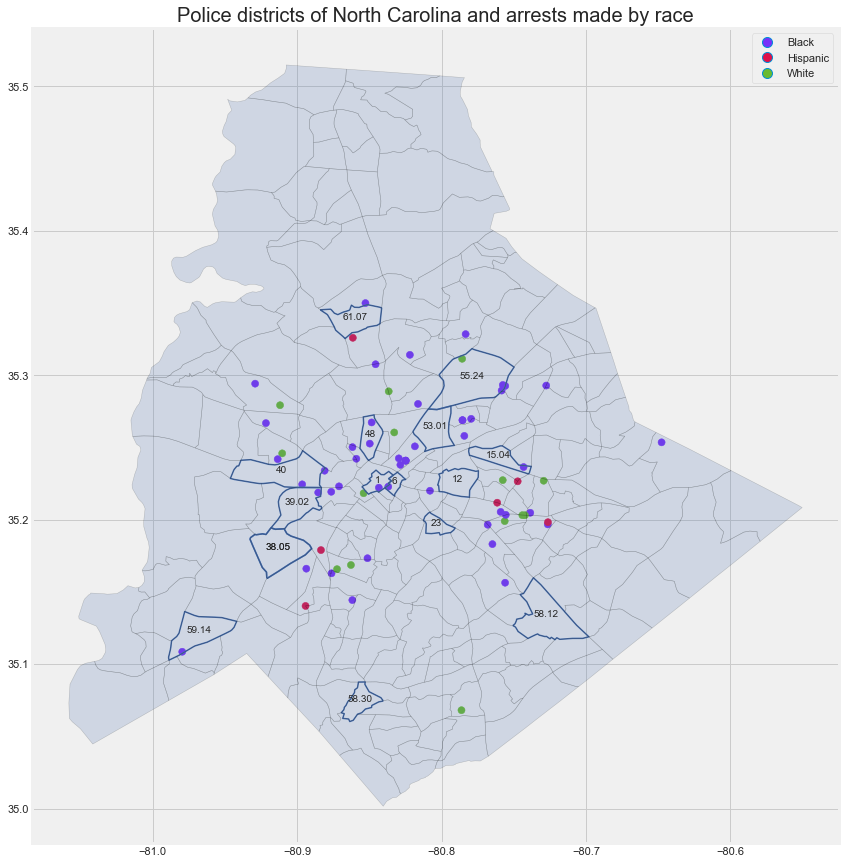

In [19]:
districts = gpd.sjoin(census_merged, police_shp_gdf, how='inner', op='intersects')
districts = districts.to_crs(epsg = 4326)

fig6, ax6 = plt.subplots()
ax6.set_title("Police districts of North Carolina and arrests made by race", fontsize=20)

police_arrest_gdf.plot(ax = ax6, markersize=50, column="SUBJECT_RACE",legend=True, cmap = cmap)

districts.plot(ax=ax6, column='NAME_left', markersize=5, edgecolor='b', color='none', linewidth = 1.5)
districts.apply(lambda x: ax6.annotate(s=x.NAME_left, xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
census_merged.plot(ax=ax6, alpha=.2, edgecolor='black')
fig6.set_size_inches(15,15)

### Results
Now we have a representation of the arrests made in relation to the police districts, so we can track the racial seperation of each district and compare them. There is a high majority of african american arrests made around the higher poverty area. 
Let's have a look at the arrests data and see if we can find any correlations.


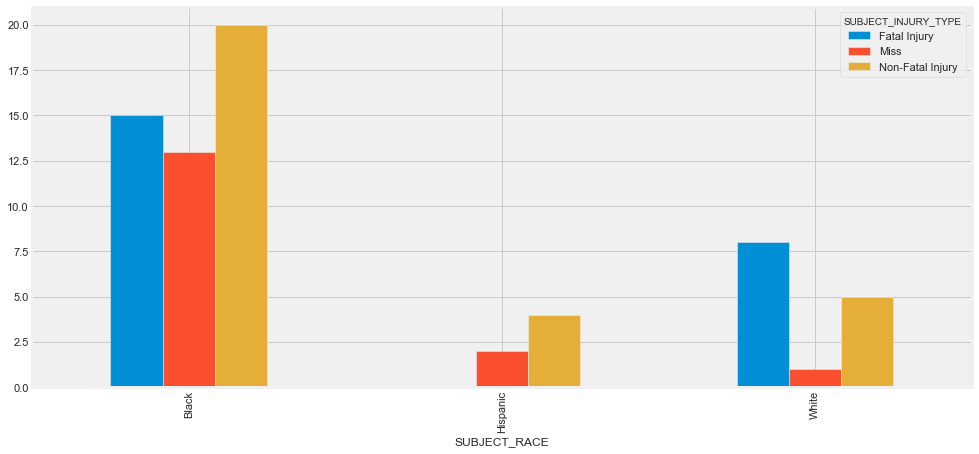

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
police_arrest_gdf.groupby(['SUBJECT_RACE', 'SUBJECT_INJURY_TYPE']).count()['INCIDENT_UNIQUE_IDENTIFIER'].unstack().plot.bar(ax=ax)

### Results
Of those arrests, a majority of them were Black, with a larger number of Fatal injuries, than any  other race. 


In [21]:
no_arrest_per_year = police_arrest_gdf['INCIDENT_YEAR'].value_counts()

year_total_df = pd.DataFrame(no_arrest_per_year.reset_index().values, columns=['year','total'])
yr_idx = year_total_df.sort_index(axis=0, ascending=True)

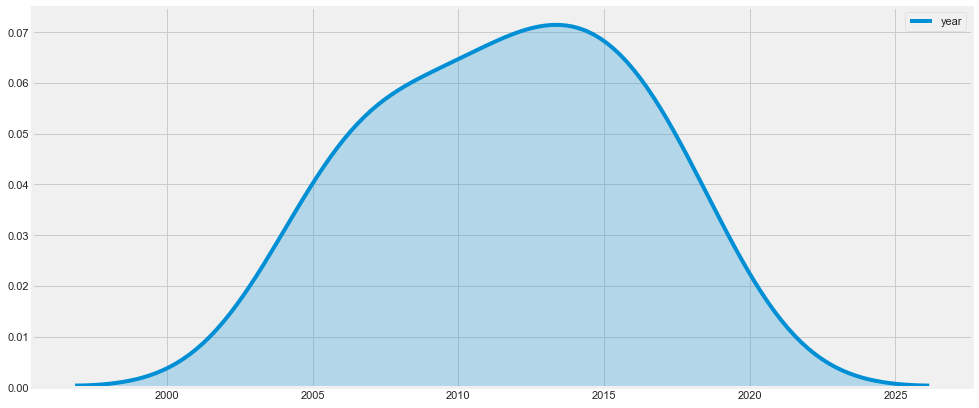

In [22]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(year_total_df['year'], shade=True, ax=ax)

### Results
A majority of the data is quite old, so the data may be bias due to changes in the census data since then. The arrests data is quite small as well ~ 80 datapoints, this may not be enough to gather true patterns. 

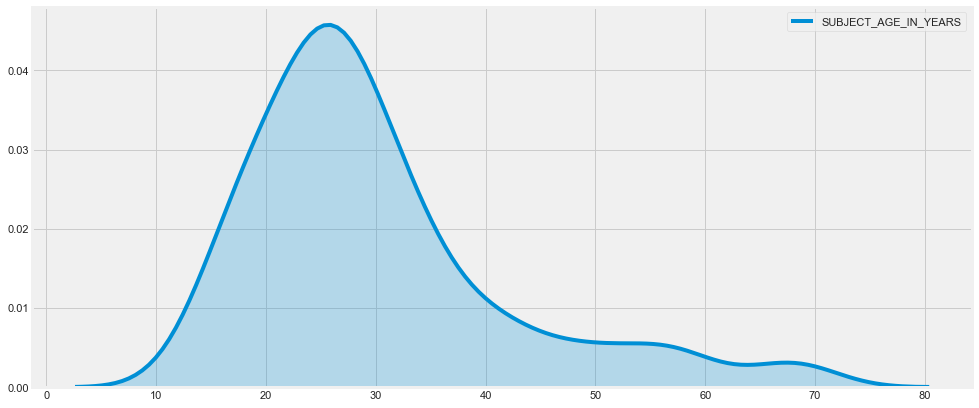

In [23]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(police_arrest_gdf['SUBJECT_AGE_IN_YEARS'], shade=True, ax=ax)

### Results
Most of the subjects were around 20-30 years of age when they got arrested. From the figure of Distribution of Poverty levels by Age, this seems to correlate with the higher levels of youth poverty. 

### Conclusion

With little data provided it is difficult to understand the nature of the arrests we see on the map as a representation of the whole state. If we can make a correlation between poverty levels and arrests, meaning areas with greater poverty will have greater arrests, then it would be safe to say there is less likelihood that arrests made on african american's in parts of the district where there is higher education has a **higher probabliity** of being an arrest based on racial profiling.